In [1]:
#Libraries needed
!pip install pyreadstat
!pip install fancyimpute

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 29.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=b5dcdb14d08b8bb2f0238f4365f1a988abb77bc787eca04b4cbac6f635144996
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11329 sha256=c1f41ed1d93d7d04b1c9f2cae4be5f445876a3d2b5d84227c55b4794059311cd
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [2]:
import pandas as pd
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
import numpy as np
from fancyimpute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report, auc, roc_curve
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import wilcoxon
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.stats.contingency_tables import mcnemar


In [3]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DATA PREPARATION - Merging data files together into one single dataframe

In [4]:
file_path = '/content/drive/MyDrive/H&S Data science Dissertation/UKDA-8156-spss-age14/spss/spss25/mcs6_parent_derived.sav'
data, meta = pyreadstat.read_sav(file_path)
parent_derived_s6 = pd.DataFrame(data)
parent_derived_s6

#######Columns (variables) of interest########
# MCSID = ID
# FDKESSL = parental score on kessler scale
# FDAUDIT = parental score on AUDIT-5 alcohol consumption
# FDACAQ00 =  NVQ equivalent of highest academic level across sweeps
##############################################

#Keeping variables of interest
parent_derived_s6_final = parent_derived_s6[['MCSID','FDKESSL', 'FDAUDIT','FDACAQ00']]
parent_derived_s6_final

#Renaming column names into more meaningful names
parent_derived_s6_final.rename(
    columns={"FDKESSL": "Parent_kessler", "FDAUDIT": "AUDIT-5-score", "FDACAQ00": "highest_academic_lvl"},
    inplace=True,
)
parent_derived_s6_final

<ipython-input-4-75cee8994f4c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parent_derived_s6_final.rename(


,MCSID,Parent_kessler,AUDIT-5-score,highest_academic_lvl
0,M10002P,1.0,3.0,2.0
1,M10002P,1.0,4.0,3.0
2,M10007U,3.0,3.0,3.0
3,M10007U,NaN,0.0,2.0
4,M10015U,2.0,3.0,4.0
...,...,...,...,...
20545,M35872K,1.0,4.0,96.0
20546,M35872K,0.0,3.0,2.0
20547,M35873L,6.0,3.0,4.0
20548,M35874M,20.0,4.0,2.0


In [5]:
file_path2 = '/content/drive/MyDrive/H&S Data science Dissertation/UKDA-8156-spss-age14/spss/spss25/mcs6_family_derived.sav'

data2, meta2 = pyreadstat.read_sav(file_path2)
family_derived_s6 = pd.DataFrame(data2)
family_derived_s6

#######Columns (variables) of interest########
# FDOTHS00 = Number of cohort's siblings in household
# FOECDUK0 = Collapses OEDE into quintiles based upon UK income distribution.
#############################################

#Keeping variables of interest
family_derived_s6_final = family_derived_s6[['MCSID','FDOTHS00', 'FOECDUK0']]
family_derived_s6_final

#Renaming column names into more meaningful names
family_derived_s6_final.rename(
    columns={"FDOTHS00": "n_siblings", "FOECDUK0": "H.Income"},
    inplace=True,
)
family_derived_s6_final

<ipython-input-5-a2ae99a10ce6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_derived_s6_final.rename(


,MCSID,n_siblings,H.Income
0,M10002P,1.0,4.0
1,M10007U,1.0,4.0
2,M10015U,2.0,5.0
3,M10016V,2.0,3.0
4,M10018X,1.0,5.0
...,...,...,...
11712,M35868P,1.0,2.0
11713,M35869Q,2.0,1.0
11714,M35872K,2.0,4.0
11715,M35873L,0.0,2.0


In [6]:
file_path3 = '/content/drive/MyDrive/H&S Data science Dissertation/UKDA-8156-spss-age14/spss/spss25/mcs6_cm_interview.sav'
data3, meta3 = pyreadstat.read_sav(file_path3)
cm_interview_s6 = pd.DataFrame(data3)
cm_interview_s6

#######Columns (variables) of interest########
#FCRLQF00 = how close child is with father
#FCRLQM00 = how close child is with mother
#FCQUAM00 = how often child argues with mother
#FCQUAF00 = how often child argues with father
################################################

#Keeping variables of interest
cm_interview_s6_final = cm_interview_s6[['MCSID','FCRLQF00', 'FCRLQM00','FCQUAM00','FCQUAF00']]
cm_interview_s6_final

#Renaming column names into more meaningful names
cm_interview_s6_final.rename(
    columns={"FCRLQF00": "CM-Father_closeness", "FCRLQM00": "CM-Mother_closeness","FCQUAM00":"CM-F_argument","FCQUAF00":"CM-M_argument"},
    inplace=True,
)
cm_interview_s6_final

<ipython-input-6-0315652dd262>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cm_interview_s6_final.rename(


,MCSID,CM-Father_closeness,CM-Mother_closeness,CM-F_argument,CM-M_argument
0,M10002P,3.0,3.0,3.0,3.0
1,M10007U,3.0,3.0,4.0,4.0
2,M10015U,4.0,4.0,3.0,3.0
3,M10016V,3.0,3.0,4.0,4.0
4,M10018X,4.0,3.0,3.0,3.0
...,...,...,...,...,...
11854,M35868P,3.0,4.0,4.0,5.0
11855,M35869Q,5.0,3.0,4.0,NaN
11856,M35872K,4.0,4.0,3.0,4.0
11857,M35873L,3.0,4.0,2.0,4.0


In [7]:
file_path5 = '/content/drive/MyDrive/H&S Data science Dissertation/UKDA-8156-spss-age14/spss/spss25/mcs6_parent_cm_interview.sav'
data5, meta5 = pyreadstat.read_sav(file_path5)
parent_cm_interview_s6 = pd.DataFrame(data5)
parent_cm_interview_s6

#######Columns (variables) of interest########
#FPSCHC00 = Perceived closeness of parents to their child
#FPQARP00 = how often parents argue with child
################################################

#Keeping variables of interest
parent_cm_interview_s6_final = parent_cm_interview_s6[['MCSID','FPSCHC00', 'FPQARP00']]
parent_cm_interview_s6_final

#Renaming column names into more meaningful names
parent_cm_interview_s6_final.rename(
    columns={"FPSCHC00": "Parent-CM_closeness", "FPQARP00": "Parent-CM_argument"},
    inplace=True,
)
parent_cm_interview_s6_final

<ipython-input-7-9c2115066b00>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parent_cm_interview_s6_final.rename(


,MCSID,Parent-CM_closeness,Parent-CM_argument
0,M10002P,4.0,3.0
1,M10002P,4.0,4.0
2,M10007U,3.0,4.0
3,M10015U,4.0,3.0
4,M10015U,4.0,4.0
...,...,...,...
19065,M35869Q,3.0,4.0
19066,M35872K,4.0,4.0
19067,M35872K,3.0,4.0
19068,M35873L,4.0,3.0


In [8]:
#Obtaining sex, ethnicity of ppt at sweep 6

#Obtaining sex of ppt
ppt_sex_14_file = '/content/drive/MyDrive/H&S Data science Dissertation/UKDA-8156-spss-age14/spss/spss25/mcs6_cm_interview.sav'
ppt_sex_14, meta_sex_14 = pyreadstat.read_sav(ppt_sex_14_file)
ppts_sex_14 = pd.DataFrame(ppt_sex_14)
ppts_sex_14
#Variables of interest (FCCSEX00 = Sex, MCSID)
ppts_sex_14_final = ppts_sex_14[['MCSID', 'FCCSEX00']]
ppts_sex_14_final

#Changing column name
ppts_sex_14_final.rename(
    columns={"FCCSEX00": "cohort_sex_14"},
    inplace=True,
)
ppts_sex_14_final


#obtaining ethnicity
ppt_ethnic_14_file = '/content/drive/MyDrive/H&S Data science Dissertation/UKDA-8156-spss-age14/spss/spss25/mcs6_cm_derived.sav'
ppt_ethnic_14, meta_ethnic_14 = pyreadstat.read_sav(ppt_ethnic_14_file)
ppts_ethnic_14 = pd.DataFrame(ppt_ethnic_14)
ppts_ethnic_14
#Variables of interest (FDCE0600 = ethnic group)
ppts_ethnic_14_final = ppts_ethnic_14[['MCSID', 'FDCE0600']]
ppts_ethnic_14_final


#Renaming column names into more meaningful names
ppts_ethnic_14_final.rename(
    columns={"FDCE0600": "ethnic_group_14"},
    inplace=True,
)

  #

<ipython-input-8-0370318b35d0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppts_sex_14_final.rename(
<ipython-input-8-0370318b35d0>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppts_ethnic_14_final.rename(


In [9]:
#Merging files within sweep 6 together
merged_s6_df = pd.merge(parent_derived_s6_final, family_derived_s6_final, on='MCSID', how='inner')
merged_s6_df = pd.merge(merged_s6_df, cm_interview_s6_final, on='MCSID', how='inner')
merged_s6_df = pd.merge(merged_s6_df, parent_cm_interview_s6_final, on='MCSID', how='inner')
merged_s6_df = pd.merge(merged_s6_df, ppts_sex_14_final, on='MCSID', how='inner')
merged_s6_df = pd.merge(merged_s6_df, ppts_ethnic_14_final, on='MCSID', how='inner')

merged_s6_df

,MCSID,Parent_kessler,AUDIT-5-score,highest_academic_lvl,n_siblings,H.Income,CM-Father_closeness,CM-Mother_closeness,CM-F_argument,CM-M_argument,Parent-CM_closeness,Parent-CM_argument,cohort_sex_14,ethnic_group_14
0,M10002P,1.0,3.0,2.0,1.0,4.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,1.0
1,M10002P,1.0,3.0,2.0,1.0,4.0,3.0,3.0,3.0,3.0,4.0,4.0,1.0,1.0
2,M10002P,1.0,4.0,3.0,1.0,4.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,1.0
3,M10002P,1.0,4.0,3.0,1.0,4.0,3.0,3.0,3.0,3.0,4.0,4.0,1.0,1.0
4,M10007U,3.0,3.0,3.0,1.0,4.0,3.0,3.0,4.0,4.0,3.0,4.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40712,M35872K,0.0,3.0,2.0,2.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,2.0,1.0
40713,M35872K,0.0,3.0,2.0,2.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,1.0
40714,M35873L,6.0,3.0,4.0,0.0,2.0,3.0,4.0,2.0,4.0,4.0,3.0,2.0,1.0
40715,M35874M,20.0,4.0,2.0,1.0,3.0,2.0,3.0,2.0,2.0,3.0,2.0,1.0,1.0


In [10]:
#outcome age 17 SDQ score
file_path6 = '/content/drive/MyDrive/H&S Data science Dissertation/UKDA-8682-spss-age17/spss/spss25/mcs7_cm_derived.sav'
data6, meta6 = pyreadstat.read_sav(file_path6)
cm_derived_s7 = pd.DataFrame(data6)
cm_derived_s7

#############OUTCOME VARIABLE#############
# GEBDTOT = outcome variable (CM's self-reported total difficulties SDQ score at age 17)
cm_derived_s7_final = cm_derived_s7[['MCSID','GEBDTOT']]
cm_derived_s7_final
###########################################

#Renaming column names into more meaningful names
cm_derived_s7_final.rename(
    columns={"GEBDTOT": "CM_SDQ17"},
    inplace=True,
)
cm_derived_s7_final

<ipython-input-10-6ed3279069ed>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cm_derived_s7_final.rename(


,MCSID,CM_SDQ17
0,M10516L,6.0
1,M28150P,4.0
2,M26490Y,27.0
3,M13264X,1.0
4,M24364K,6.0
...,...,...
10947,M18453W,NaN
10948,M24709Q,0.0
10949,M32715K,2.0
10950,M30647G,2.0


In [11]:
##Merging files containing predicters from sweep 6 and files containing outcome variable from sweep 7
dataset = pd.merge(merged_s6_df, cm_derived_s7_final, on='MCSID', how='inner')


#As merging uses inner method, rows containing missing data from certain columns will be disregarded
dataset.info()
#intial number of rows: 40,172

dataset = dataset.drop('MCSID', axis=1)
dataset


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40173 entries, 0 to 40172
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MCSID                 40173 non-null  object 
 1   Parent_kessler        36758 non-null  float64
 2   AUDIT-5-score         40173 non-null  float64
 3   highest_academic_lvl  39348 non-null  float64
 4   n_siblings            40173 non-null  float64
 5   H.Income              40143 non-null  float64
 6   CM-Father_closeness   39121 non-null  float64
 7   CM-Mother_closeness   39128 non-null  float64
 8   CM-F_argument         38794 non-null  float64
 9   CM-M_argument         37688 non-null  float64
 10  Parent-CM_closeness   39416 non-null  float64
 11  Parent-CM_argument    39303 non-null  float64
 12  cohort_sex_14         40173 non-null  float64
 13  ethnic_group_14       39248 non-null  float64
 14  CM_SDQ17              35429 non-null  float64
dtypes: float64(14), obj

,Parent_kessler,AUDIT-5-score,highest_academic_lvl,n_siblings,H.Income,CM-Father_closeness,CM-Mother_closeness,CM-F_argument,CM-M_argument,Parent-CM_closeness,Parent-CM_argument,cohort_sex_14,ethnic_group_14,CM_SDQ17
0,1.0,3.0,2.0,1.0,4.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,1.0,4.0
1,1.0,3.0,2.0,1.0,4.0,3.0,3.0,3.0,3.0,4.0,4.0,1.0,1.0,4.0
2,1.0,4.0,3.0,1.0,4.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,1.0,4.0
3,1.0,4.0,3.0,1.0,4.0,3.0,3.0,3.0,3.0,4.0,4.0,1.0,1.0,4.0
4,3.0,3.0,3.0,1.0,4.0,3.0,3.0,4.0,4.0,3.0,4.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40168,1.0,4.0,96.0,2.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,1.0,NaN
40169,0.0,3.0,2.0,2.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,2.0,1.0,NaN
40170,0.0,3.0,2.0,2.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,1.0,NaN
40171,20.0,4.0,2.0,1.0,3.0,2.0,3.0,2.0,2.0,3.0,2.0,1.0,1.0,9.0


In [36]:
#Converting merged dataframe into excel file

# file path
excel_file_path = 'merged_dataset.xlsx'

dataset.to_excel(excel_file_path, index=False)

DATA PRE-PROCESSING

1.Data cleaning
- Missing data --> multiple imputation
- Check for duplicated rows
- EDA

3.Data transformation
- Transform target/outcome variable into binary classes (high vs low risk) based on threshold score of 17
- Data visualisation of outcome variable
- Handle class imbalance --> SMOTE?
- Data visualisation of features
- Data standardisation

4.Checking for redundant features
- correlation plot
- removing redundant attributes based on correlation coefficient

5.Data splitting

6.Data standardisation


In [12]:
#Correcting datatypes (highest_academic_lvl, n_siblings, h.Income, cohort_sex_14, ethnic_group_14)
# highest_academic_lvl --> categorical
dataset['highest_academic_lvl'] = dataset['highest_academic_lvl'].astype('category')
# n_siblings --> int
dataset['n_siblings'] = dataset['n_siblings'].astype('int')
# H.Income --> categorical
dataset['H.Income'] = dataset['H.Income'].astype('category')
# cohort_sex_14 --> categorical
dataset['cohort_sex_14'] = dataset['cohort_sex_14'].astype('category')
# ethnic_group_14 --> categorical
dataset['ethnic_group_14'] = dataset['ethnic_group_14'].astype('category')

dataset.dtypes #Checking final data types
#dataset

Parent_kessler           float64
AUDIT-5-score            float64
highest_academic_lvl    category
n_siblings                 int64
H.Income                category
CM-Father_closeness      float64
CM-Mother_closeness      float64
CM-F_argument            float64
CM-M_argument            float64
Parent-CM_closeness      float64
Parent-CM_argument       float64
cohort_sex_14           category
ethnic_group_14         category
CM_SDQ17                 float64
dtype: object

In [13]:
#Checking for missing values
dataset.isnull().sum() #Missing values present : Parent_kessler, highest_academic_lvl, H.Income, CM-Father_closeness, CM-Mother_closeness, CM-F_argument, CM-M_argument, Parent-CM_closeness, Parent-CM_argument, ethnic_group_14, CM_SDQ17

#Multiple imputation to combat missing values for columns with float/int dtypes
impute_columns = ["Parent_kessler",'CM-Father_closeness', 'CM-Mother_closeness', 'CM-F_argument', 'CM-M_argument','Parent-CM_closeness','Parent-CM_argument','CM_SDQ17']

  # creating another dataframe with only columns above
imputed_dataset = dataset[impute_columns].copy()

  #Multiple imputation on columns above
imputer = IterativeImputer(random_state=260744)
imputed_dataset = pd.DataFrame(imputer.fit_transform(imputed_dataset), columns=impute_columns)
imputed_dataset.isnull().sum() #checking if imputation worked

  #Merging imputed columns with original dataset
dataset[impute_columns] = imputed_dataset


#Using Mode imputation to for imputating categorical values (highest_academic_lvl, H.Income, ethnic_group_14).
  #Mode imputation used to maintain original distribution of data by using most commonly observed value as replacement for missing value.

imputed_columns = ['highest_academic_lvl','H.Income','ethnic_group_14']


  # mode imputation on the  columns above
for column in imputed_columns:
    replacement_value = dataset[column].mode().iloc[0]
    dataset[column] = dataset[column].fillna(replacement_value)  # Impute missing values with the mode

dataset.isnull().sum() #checking if multiple imputation worked


Parent_kessler          0
AUDIT-5-score           0
highest_academic_lvl    0
n_siblings              0
H.Income                0
CM-Father_closeness     0
CM-Mother_closeness     0
CM-F_argument           0
CM-M_argument           0
Parent-CM_closeness     0
Parent-CM_argument      0
cohort_sex_14           0
ethnic_group_14         0
CM_SDQ17                0
dtype: int64

In [14]:
#Check for duplicated rows
dataset.duplicated().sum() # duplicated rows = 11,261
clean_dataset = dataset.drop_duplicates()
print('Total number of rows left:', len(clean_dataset)) #28,912 total number of rows leftover

#Checking for missing values
clean_dataset.isnull().sum() #No missing values left

clean_dataset.head() #prints the first 5 row of dataset

Total number of rows left: 28912


,Parent_kessler,AUDIT-5-score,highest_academic_lvl,n_siblings,H.Income,CM-Father_closeness,CM-Mother_closeness,CM-F_argument,CM-M_argument,Parent-CM_closeness,Parent-CM_argument,cohort_sex_14,ethnic_group_14,CM_SDQ17
0,1.0,3.0,2.0,1,4.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,1.0,4.0
1,1.0,3.0,2.0,1,4.0,3.0,3.0,3.0,3.0,4.0,4.0,1.0,1.0,4.0
2,1.0,4.0,3.0,1,4.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,1.0,4.0
3,1.0,4.0,3.0,1,4.0,3.0,3.0,3.0,3.0,4.0,4.0,1.0,1.0,4.0
4,3.0,3.0,3.0,1,4.0,3.0,3.0,4.0,4.0,3.0,4.0,1.0,1.0,2.0


In [37]:
#Converting merged dataframe into excel file

# file path
excel_file_path = 'cleaned_dataset.xlsx'

clean_dataset.to_excel(excel_file_path, index=False)

In [15]:
#Transforming target variable CM_SDQ17 into binary classes (low risk = less than 17. High risk = 17 and above)
clean_dataset['Mental_health17'] = clean_dataset['CM_SDQ17'].apply(lambda x: 1 if x >= 17 else 0)
clean_dataset #0 = low-risk. 1 = high-risk in developing mental health

#Getting rid of CM_SDQ17 column as this is no longer needed
clean_dataset = clean_dataset.drop('CM_SDQ17', axis=1)
clean_dataset

<ipython-input-15-66077f0fe66a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset['Mental_health17'] = clean_dataset['CM_SDQ17'].apply(lambda x: 1 if x >= 17 else 0)


,Parent_kessler,AUDIT-5-score,highest_academic_lvl,n_siblings,H.Income,CM-Father_closeness,CM-Mother_closeness,CM-F_argument,CM-M_argument,Parent-CM_closeness,Parent-CM_argument,cohort_sex_14,ethnic_group_14,Mental_health17
0,1.000000,3.0,2.0,1,4.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,1.0,0
1,1.000000,3.0,2.0,1,4.0,3.0,3.0,3.0,3.0,4.0,4.0,1.0,1.0,0
2,1.000000,4.0,3.0,1,4.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,1.0,0
3,1.000000,4.0,3.0,1,4.0,3.0,3.0,3.0,3.0,4.0,4.0,1.0,1.0,0
4,3.000000,3.0,3.0,1,4.0,3.0,3.0,4.0,4.0,3.0,4.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40168,1.000000,4.0,96.0,2,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,1.0,0
40169,0.000000,3.0,2.0,2,4.0,4.0,4.0,3.0,4.0,4.0,4.0,2.0,1.0,0
40170,0.000000,3.0,2.0,2,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,1.0,0
40171,20.000000,4.0,2.0,1,3.0,2.0,3.0,2.0,2.0,3.0,2.0,1.0,1.0,0


EXPLORATORY DATA ANALYSIS

Sample characteristics of cohort members

In [16]:
clean_dataset['cohort_sex_14'].value_counts()

2.0    14652
1.0    14260
Name: cohort_sex_14, dtype: int64

In [17]:
#Obtaining number of male and females cohort members
clean_dataset['cohort_sex_14'].value_counts() # 1=Male 2=Female

#Obtaining count per ethnicity of cohort members
clean_dataset['ethnic_group_14'].value_counts() # 1=white 2=mixed 3=indian 4=Pakistani and Bangladeshi 5=Black or Black British 6=Other Ethnic group (inc Chinese,Other)

#count per household income category
clean_dataset['H.Income'].value_counts() #1=bottom 2=second 3=third 4=fourth 5=top

#count per highest parental education category
clean_dataset['highest_academic_lvl'].value_counts() #1=NVQ level 1, 2=NVQ level 2, 3=NVQ level 3, 4=NVQ level 4, 5=NVQ level 5, 95=Overseas qual only, 96=None of these


4.0     10421
2.0      6383
3.0      3805
5.0      3681
96.0     2286
1.0      1470
95.0      866
Name: highest_academic_lvl, dtype: int64

Descriptive statistics

In [18]:
# Columns for calculating desc stats
columns_of_interest = ['Parent_kessler','AUDIT-5-score','n_siblings','CM-Father_closeness',
                       'CM-Mother_closeness','CM-F_argument','CM-M_argument','Parent-CM_closeness','Parent-CM_argument'
]

# Initialize dictionaries to store the results
descriptive_stats = {
    'mean': {},
    'median': {},
    'std_dev': {},
    'range': {}
}

# Iterate through columns of interest
for column in columns_of_interest:
    column_data = clean_dataset[column]

    # mean
    mean = column_data.mean()
    descriptive_stats['mean'][column] = mean

    # median
    median = column_data.median()
    descriptive_stats['median'][column] = median

    # standard deviation
    std_dev = column_data.std()
    descriptive_stats['std_dev'][column] = std_dev

    # range of values
    data_range = column_data.max() - column_data.min()
    descriptive_stats['range'][column] = data_range

# results per column
for stat_name, stat_values in descriptive_stats.items():
    print(f"{stat_name.capitalize()}:")
    for column, value in stat_values.items():
        print(f"Column '{column}': {value}")
    print()

Mean:
Column 'Parent_kessler': 4.0358247721263245
Column 'AUDIT-5-score': 2.614934975096846
Column 'n_siblings': 1.5352448810182624
Column 'CM-Father_closeness': 3.0469405297222534
Column 'CM-Mother_closeness': 3.2517153681205904
Column 'CM-F_argument': 3.156468095261464
Column 'CM-M_argument': 3.449711016112984
Column 'Parent-CM_closeness': 3.189963310339208
Column 'Parent-CM_argument': 3.023244921397247

Median:
Column 'Parent_kessler': 3.0
Column 'AUDIT-5-score': 2.0
Column 'n_siblings': 1.0
Column 'CM-Father_closeness': 3.0
Column 'CM-Mother_closeness': 3.0
Column 'CM-F_argument': 3.0
Column 'CM-M_argument': 4.0
Column 'Parent-CM_closeness': 3.0
Column 'Parent-CM_argument': 3.0

Std_dev:
Column 'Parent_kessler': 3.7108081446915224
Column 'AUDIT-5-score': 2.3761354223663256
Column 'n_siblings': 1.1317377447670707
Column 'CM-Father_closeness': 0.9582804709533695
Column 'CM-Mother_closeness': 0.7807769801923284
Column 'CM-F_argument': 1.011720355983122
Column 'CM-M_argument': 0.988090

 0    26947
1     1965
Name: Mental_health17, dtype: int64


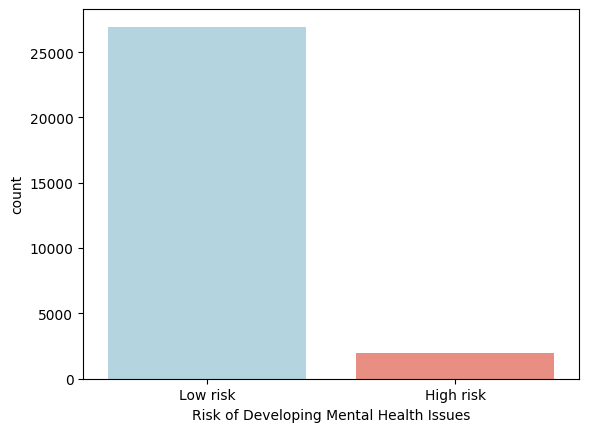

In [19]:
#Distribution of mental health outcome at age 17
sns.set_palette(['lightblue', 'salmon'])
sns.countplot(x="Mental_health17", data=clean_dataset) #Highly imabalanced class (fewer high-risk individuals than low-risk)
plt.xlabel('Risk of Developing Mental Health Issues')
plt.xticks(ticks=[0, 1],
           labels=['Low risk', 'High risk'])
print("", clean_dataset['Mental_health17'].value_counts()) #Low risk = 26,947. High risk = 1965

#Due to class imbalance, SMOTE will be applied later.

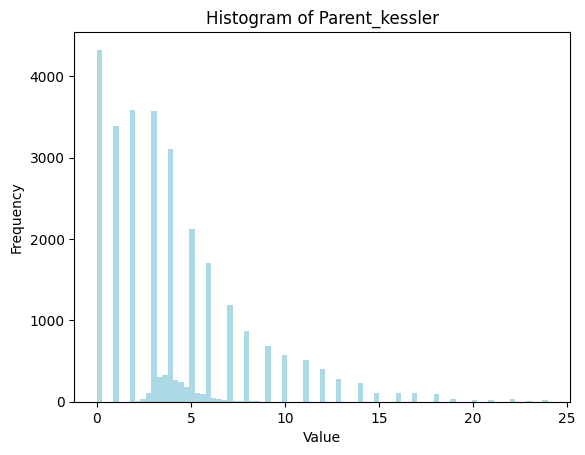

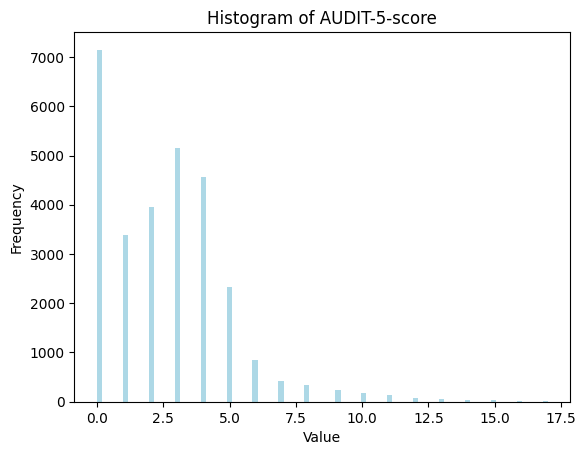

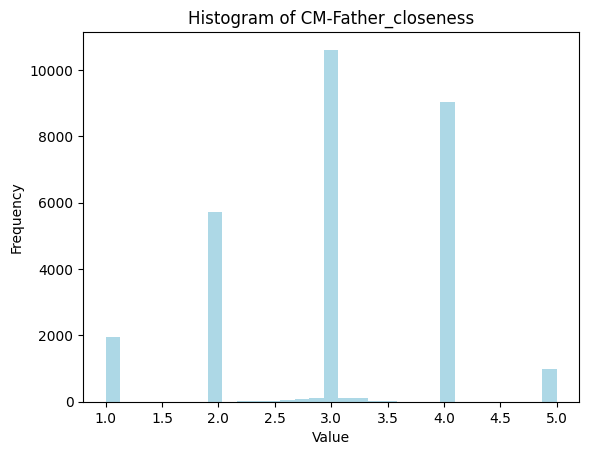

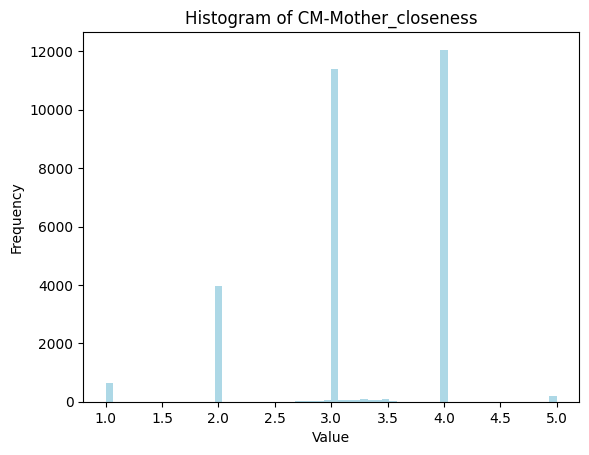

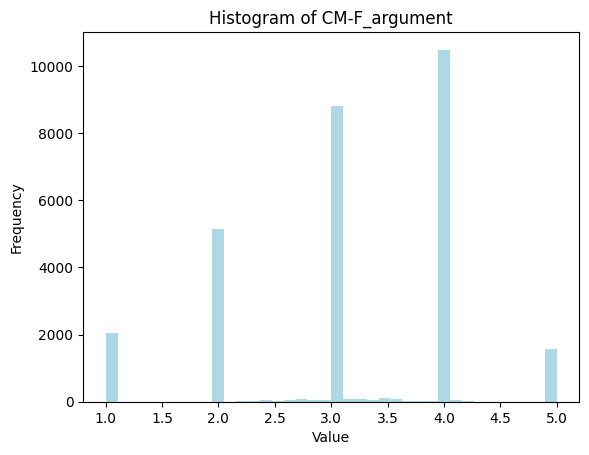

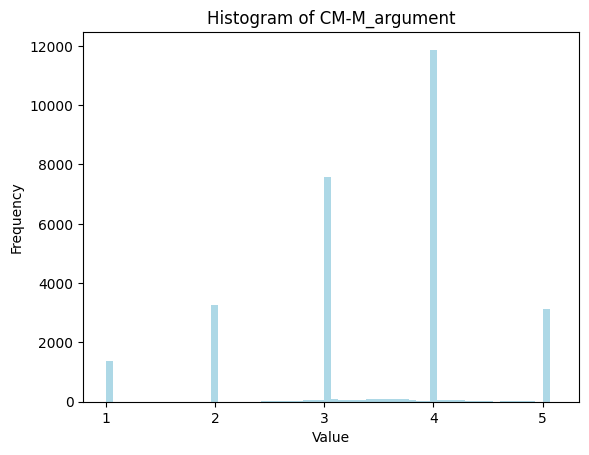

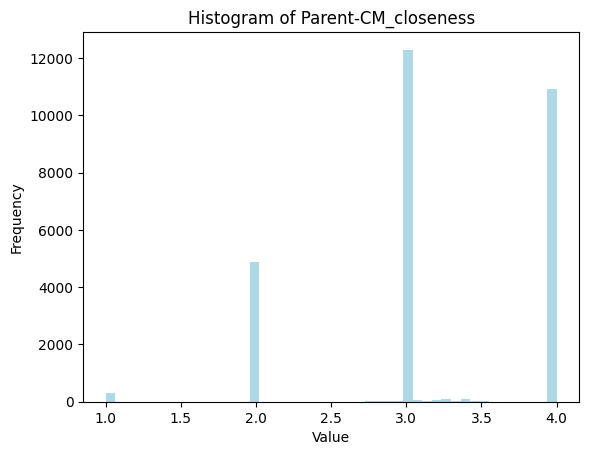

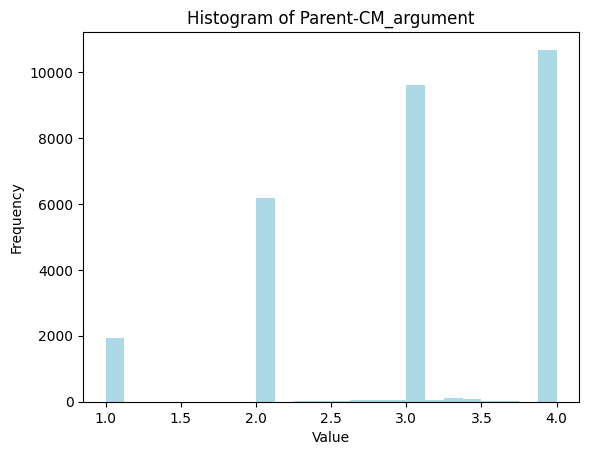

In [20]:
#Data visualisation of features

#Histogram
# Histograms to examine distribution of features with float dtypes
for predictors14 in clean_dataset.columns:
    if clean_dataset[predictors14].dtype == 'float64':
      plt.hist(clean_dataset[predictors14], bins='auto')
      plt.title("Histogram of {}".format(predictors14))
      plt.xlabel("Value")
      plt.ylabel("Frequency")
      plt.show()



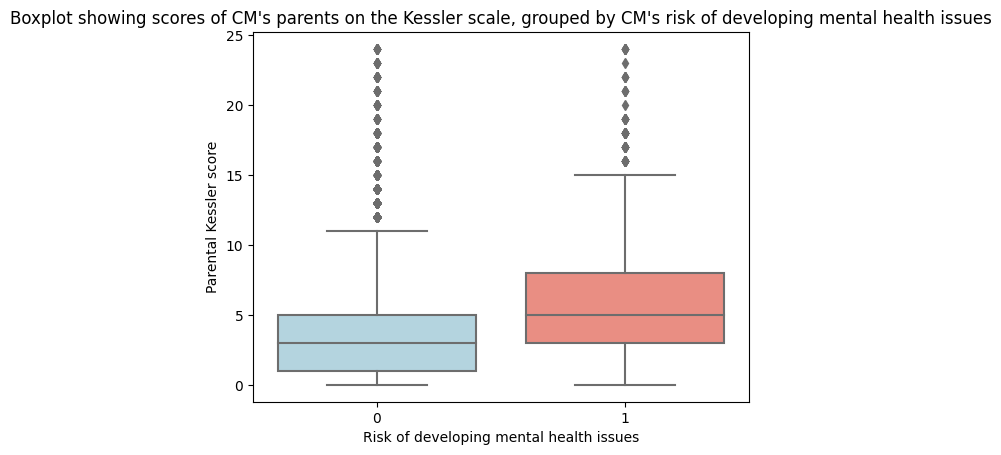

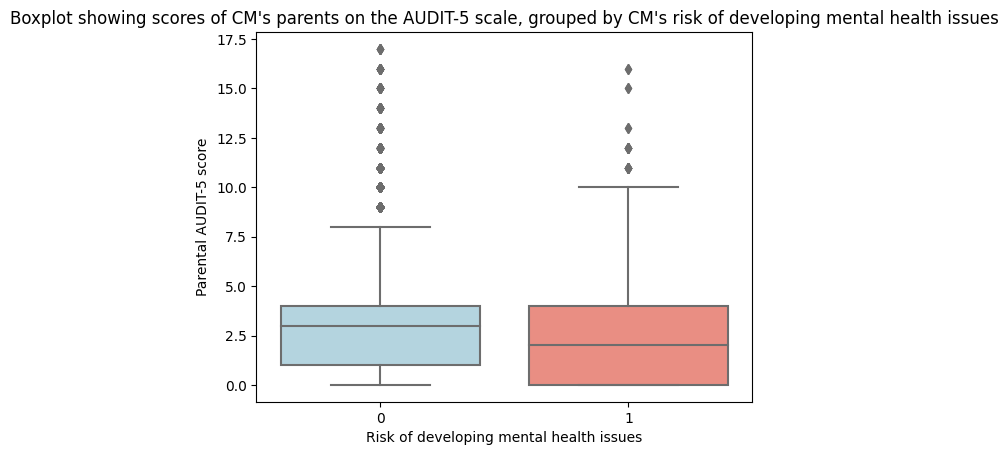

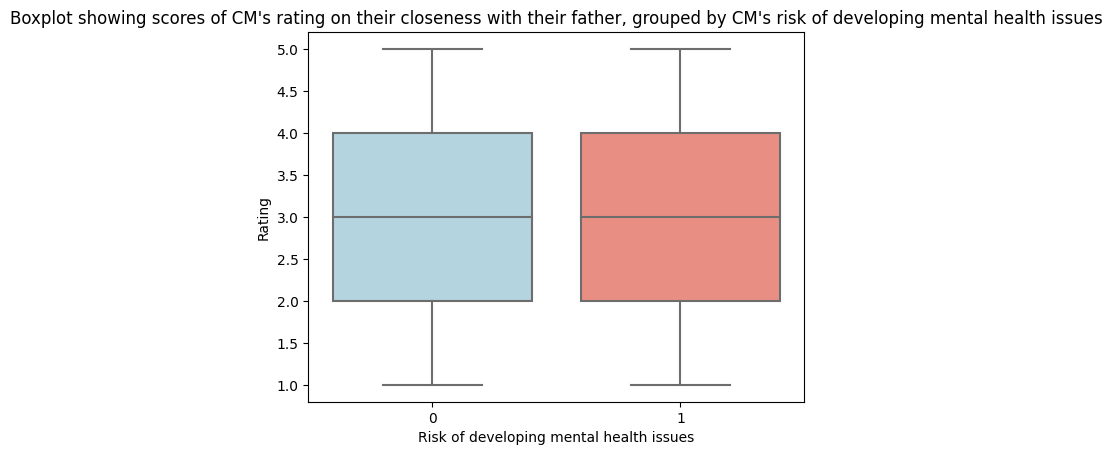

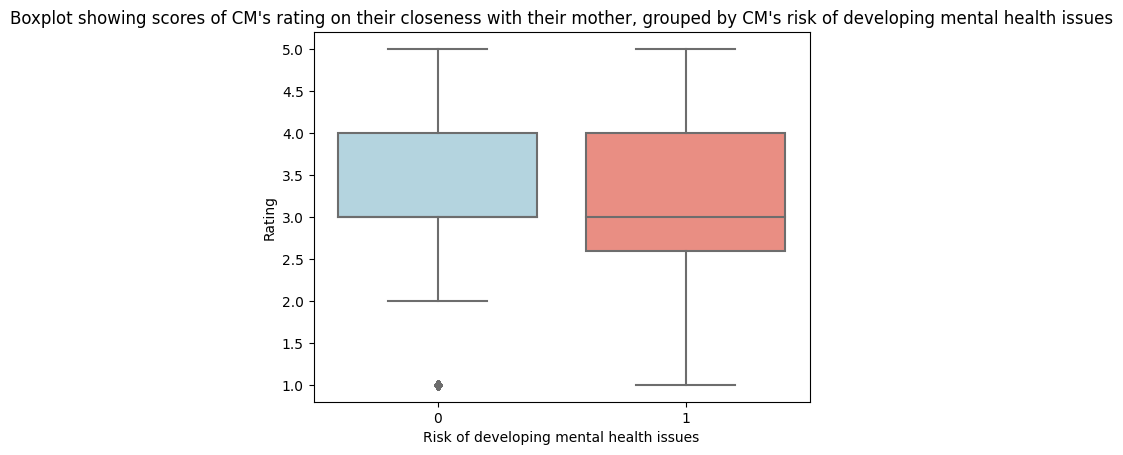

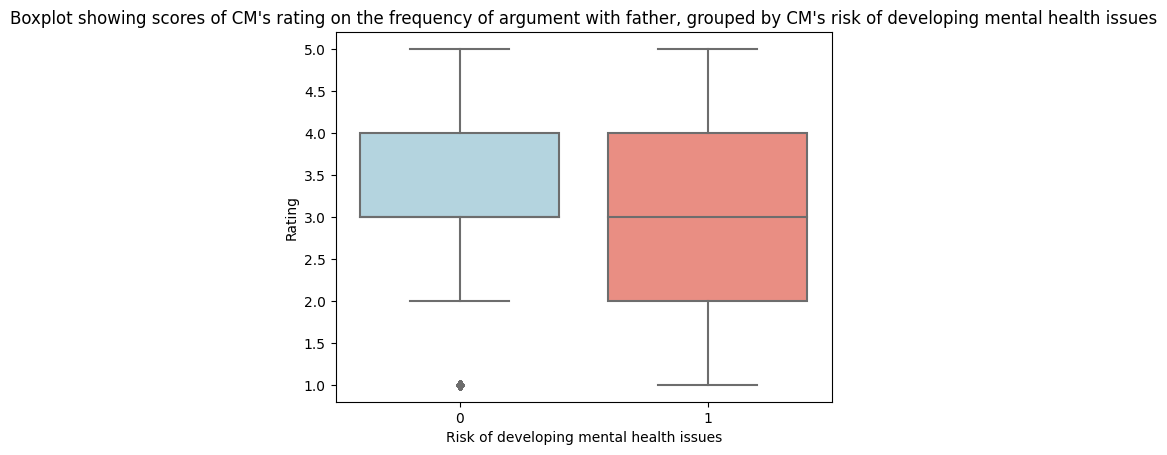

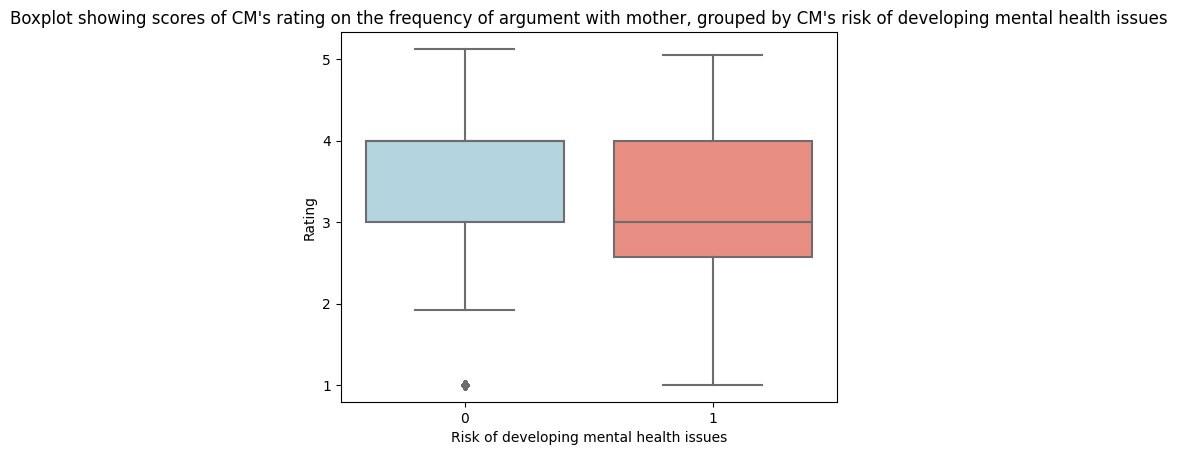

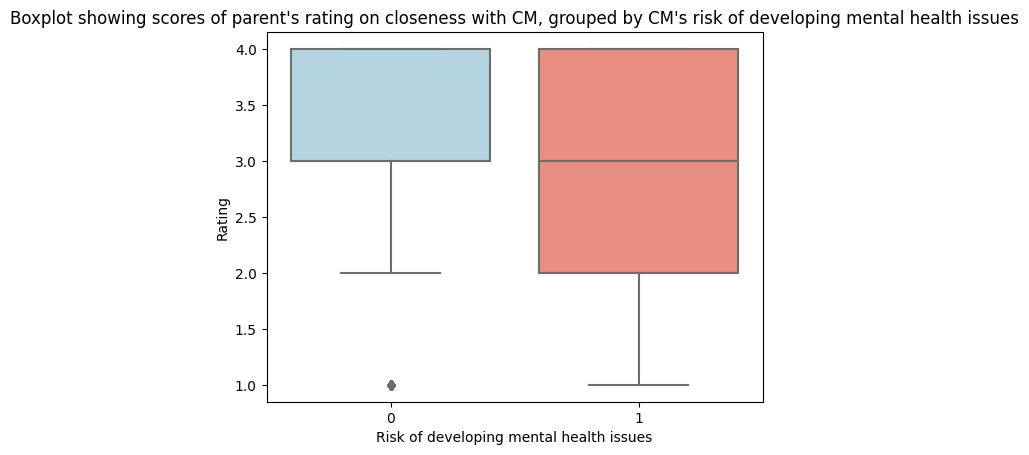

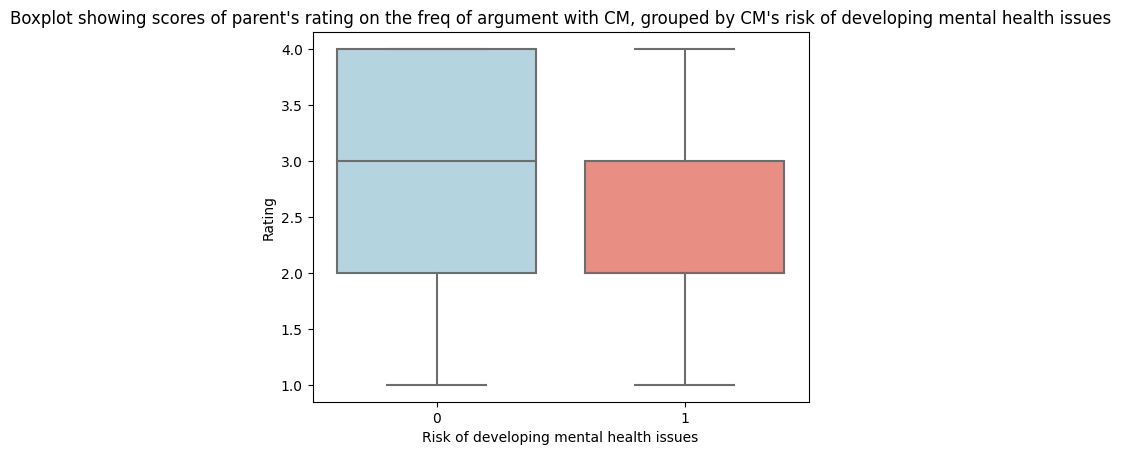

In [21]:
#Boxplot for each predictor variable

#Parent kessler score of cohort member's parents
sns.boxplot(x='Mental_health17', y='Parent_kessler', data=clean_dataset)
plt.title("Boxplot showing scores of CM's parents on the Kessler scale, grouped by CM's risk of developing mental health issues")
plt.xlabel("Risk of developing mental health issues")
plt.ylabel("Parental Kessler score")
plt.show()

#AUDIT-5 score of cohort member's parents
sns.boxplot(x='Mental_health17', y='AUDIT-5-score', data=clean_dataset)
plt.title("Boxplot showing scores of CM's parents on the AUDIT-5 scale, grouped by CM's risk of developing mental health issues")
plt.xlabel("Risk of developing mental health issues")
plt.ylabel("Parental AUDIT-5 score")
plt.show()

#Rating of closeness CM's closeness with father
sns.boxplot(x='Mental_health17', y='CM-Father_closeness', data=clean_dataset)
plt.title("Boxplot showing scores of CM's rating on their closeness with their father, grouped by CM's risk of developing mental health issues")
plt.xlabel("Risk of developing mental health issues")
plt.ylabel("Rating")
plt.show()

#Rating of closeness CM's closeness with mother
sns.boxplot(x='Mental_health17', y='CM-Mother_closeness', data=clean_dataset)
plt.title("Boxplot showing scores of CM's rating on their closeness with their mother, grouped by CM's risk of developing mental health issues")
plt.xlabel("Risk of developing mental health issues")
plt.ylabel("Rating")
plt.show()

#CM's rating of freq of arguments with father
sns.boxplot(x='Mental_health17', y='CM-F_argument', data=clean_dataset)
plt.title("Boxplot showing scores of CM's rating on the frequency of argument with father, grouped by CM's risk of developing mental health issues")
plt.xlabel("Risk of developing mental health issues")
plt.ylabel("Rating")
plt.show()

#CM's rating of freq of arguments with mother
sns.boxplot(x='Mental_health17', y='CM-M_argument', data=clean_dataset)
plt.title("Boxplot showing scores of CM's rating on the frequency of argument with mother, grouped by CM's risk of developing mental health issues")
plt.xlabel("Risk of developing mental health issues")
plt.ylabel("Rating")
plt.show()

#Parent's rating of closeness with CM
sns.boxplot(x='Mental_health17', y='Parent-CM_closeness', data=clean_dataset)
plt.title("Boxplot showing scores of parent's rating on closeness with CM, grouped by CM's risk of developing mental health issues")
plt.xlabel("Risk of developing mental health issues")
plt.ylabel("Rating")
plt.show()

#Parent's rating of freq of arguments with CM
sns.boxplot(x='Mental_health17', y='Parent-CM_argument', data=clean_dataset)
plt.title("Boxplot showing scores of parent's rating on the freq of argument with CM, grouped by CM's risk of developing mental health issues")
plt.xlabel("Risk of developing mental health issues")
plt.ylabel("Rating")
plt.show()



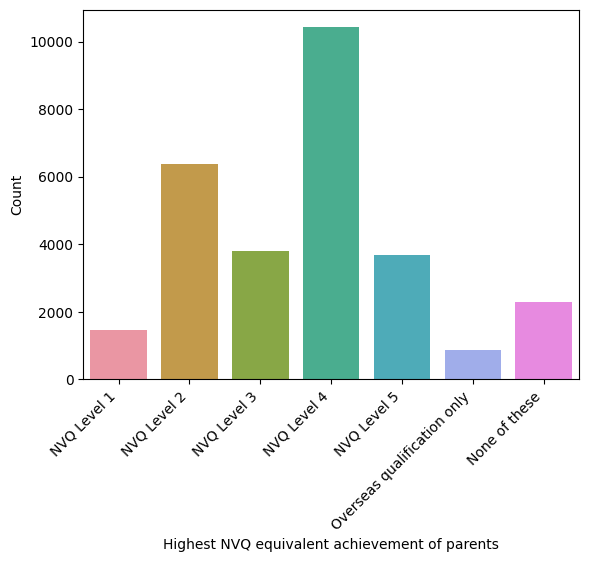

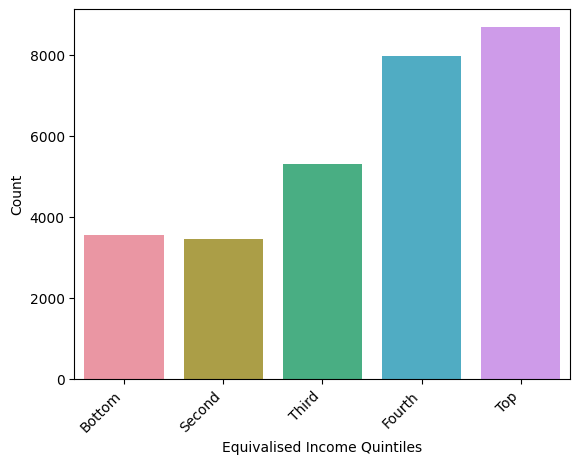

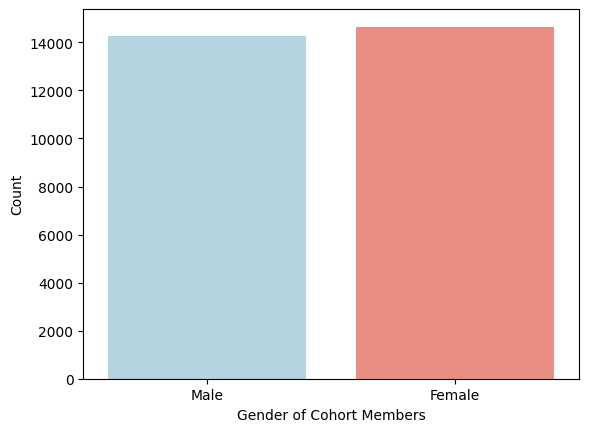

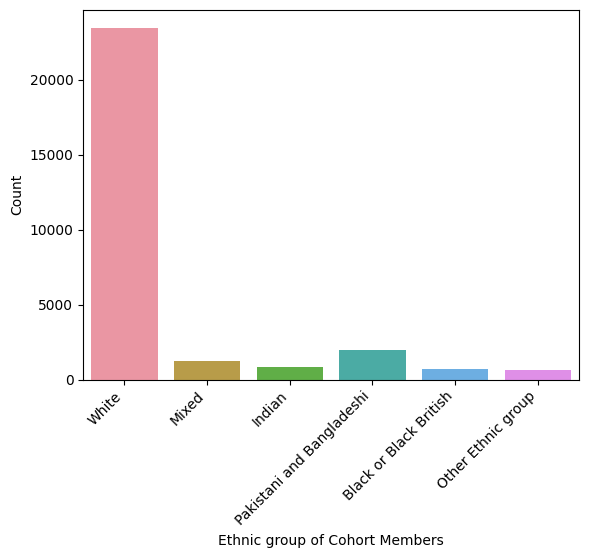

In [22]:
#Visualising distribution of categorical predictor variables with bar charts
clean_dataset.dtypes #Bar charts for highest_academic_lvl, H.Income, cohort_sex_14, ethnic_group_14

#Count plot for highest_academic_lvl
sns.countplot(data=clean_dataset, x='highest_academic_lvl')
plt.xlabel('Highest NVQ equivalent achievement of parents')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1,2,3,4,5,6],
           labels=['NVQ Level 1', 'NVQ Level 2','NVQ Level 3','NVQ Level 4','NVQ Level 5','Overseas qualification only','None of these'],
           rotation=45, ha='right')
#plt.title('Bar chart showing the distrubtion of the highest NVQ equivalent qualification obtained by parents of CM across all sweeps')
plt.show()



#Count plot for H.Income
sns.countplot(data=clean_dataset, x='H.Income')
plt.xlabel('Equivalised Income Quintiles')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1,2,3,4],
           labels=['Bottom', 'Second','Third','Fourth','Top'],
           rotation=45, ha='right')
plt.show()



#Count plot for cohort_sex_14
sns.countplot(data=clean_dataset, x='cohort_sex_14')
plt.xlabel('Gender of Cohort Members')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1],
           labels=['Male', 'Female'])
plt.show()

#Count plot for ethnic_group_14
sns.countplot(data=clean_dataset, x='ethnic_group_14')
plt.xlabel('Ethnic group of Cohort Members')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1,2,3,4,5],
           labels=['White', 'Mixed','Indian','Pakistani and Bangladeshi','Black or Black British','Other Ethnic group'],
           rotation=45, ha='right')
plt.show()


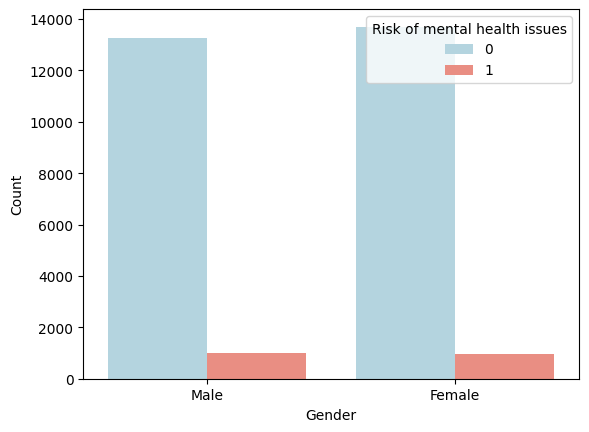

In [23]:
#Visualising distribution of high risk vs low risk individuals in mental health issues grouped by sex

  #Checking data type of variables
clean_dataset.dtypes #Mental_health17 variable needs to be changed to categorical before plotting graphs
clean_dataset['Mental_health17'] = clean_dataset['Mental_health17'].astype('category')


# Grouping by gender + mental health + count
n_gender = clean_dataset.groupby(['cohort_sex_14', 'Mental_health17']).size().reset_index(name='Count')

# Creating bar graph
sns.set_palette(['lightblue', 'salmon'])
ax = sns.barplot(x='cohort_sex_14', y='Count', hue='Mental_health17', data=n_gender)

# labels and title
plt.xlabel('Gender')
plt.ylabel('Count')
#plt.title('Figure 1: Distribution of high risk and low risk individuals in developing Mental Health Issues by Gender')

#Changing labels
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.legend(title='Risk of mental health issues')

# Show the plot
plt.show()

In [24]:
gender_counts = clean_dataset.groupby(['Mental_health17', 'cohort_sex_14']).size().unstack(fill_value=0)
print(gender_counts)


cohort_sex_14      1.0    2.0
Mental_health17              
0                13245  13702
1                 1015    950


SMOTE

Parent_kessler             0
AUDIT-5-score              0
highest_academic_lvl       0
n_siblings                 0
H.Income                   0
CM-Father_closeness        0
CM-Mother_closeness        0
CM-F_argument              0
CM-M_argument              0
Parent-CM_closeness        0
Parent-CM_argument         0
cohort_sex_14           6787
ethnic_group_14         2501
Mental_health17            0
dtype: int64

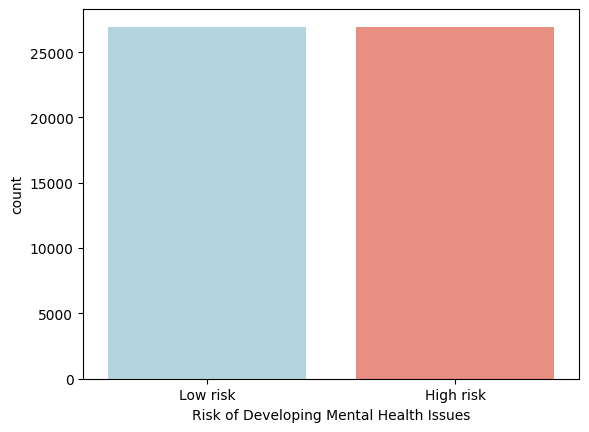

In [25]:
#Using SMOTENC as my dataset contains a mixture of categorical and numerical variables
x = clean_dataset.drop('Mental_health17', axis=1)
y = clean_dataset['Mental_health17'] # outcome only

smote_nc = SMOTENC(categorical_features=[2, 4], random_state=260744)
x_new, y_new = smote_nc.fit_resample(x, y)

#putting x_new and y_new together in new dataframe
clean_dataset1 = pd.concat([pd.DataFrame(x_new), pd.DataFrame(y_new)], axis=1)
clean_dataset1.columns = clean_dataset.columns
sns.countplot(x="Mental_health17", data=clean_dataset1)
plt.xlabel('Risk of Developing Mental Health Issues')
plt.xticks(ticks=[0, 1], labels=['Low risk', 'High risk'])

clean_dataset1.isnull().sum() #cohort_sex_14 and ethnic_group_14 still contain missing values but these variables won't be included in ML models

In [26]:
clean_dataset1

,Parent_kessler,AUDIT-5-score,highest_academic_lvl,n_siblings,H.Income,CM-Father_closeness,CM-Mother_closeness,CM-F_argument,CM-M_argument,Parent-CM_closeness,Parent-CM_argument,cohort_sex_14,ethnic_group_14,Mental_health17
0,1.000000,3.000000,2.0,1,4.0,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,1.0,1.0,0
1,1.000000,3.000000,2.0,1,4.0,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,1.0,1.0,0
2,1.000000,4.000000,3.0,1,4.0,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,1.0,1.0,0
3,1.000000,4.000000,3.0,1,4.0,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,1.0,1.0,0
4,3.000000,3.000000,3.0,1,4.0,3.000000,3.000000,4.000000,4.000000,3.000000,4.000000,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53889,4.000000,3.000000,4.0,0,5.0,1.195743,3.000000,2.195743,3.000000,3.000000,4.000000,2.0,1.0,1
53890,8.000000,0.000000,2.0,1,3.0,1.000000,3.000000,3.000000,1.000000,4.000000,1.692294,2.0,1.0,1
53891,6.828291,0.000000,4.0,1,1.0,2.852874,2.929761,2.232161,2.330337,2.000000,1.366161,1.0,1.0,1
53892,12.933855,0.066145,2.0,0,1.0,3.000000,2.000000,3.000000,3.000000,2.066145,2.933855,NaN,1.0,1


<ipython-input-27-c7e9db09d9fb>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=clean_dataset1.corr(), mask=np.triu(clean_dataset1.corr()), annot=True)


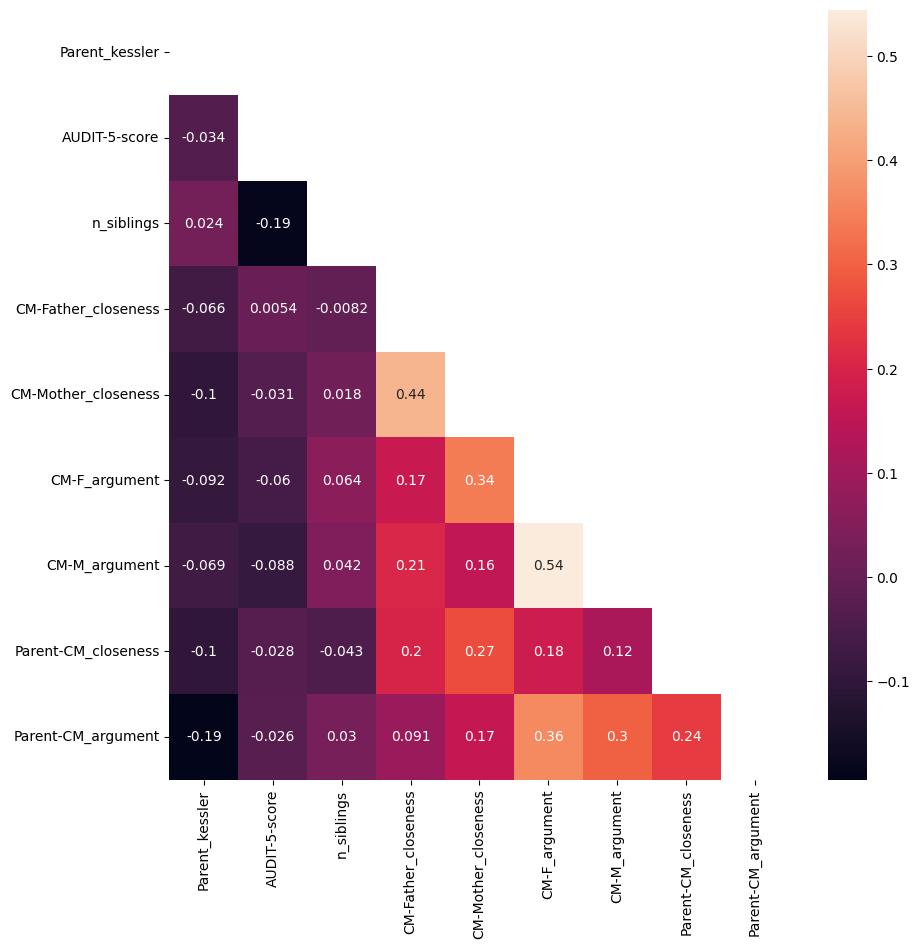

In [27]:
#Correlation between predictors to examine presense of redundant features
plt.figure(figsize=(10, 10))
sns.heatmap(data=clean_dataset1.corr(), mask=np.triu(clean_dataset1.corr()), annot=True)
plt.show()
  #No redundant features as there's no high correlation between features (more than 0.9)



LABEL ENCODING (Converting categorical variables into numerical form)

In [28]:
clean_dataset1.info() #

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53894 entries, 0 to 53893
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Parent_kessler        53894 non-null  float64 
 1   AUDIT-5-score         53894 non-null  float64 
 2   highest_academic_lvl  53894 non-null  category
 3   n_siblings            53894 non-null  int64   
 4   H.Income              53894 non-null  category
 5   CM-Father_closeness   53894 non-null  float64 
 6   CM-Mother_closeness   53894 non-null  float64 
 7   CM-F_argument         53894 non-null  float64 
 8   CM-M_argument         53894 non-null  float64 
 9   Parent-CM_closeness   53894 non-null  float64 
 10  Parent-CM_argument    53894 non-null  float64 
 11  cohort_sex_14         47107 non-null  category
 12  ethnic_group_14       51393 non-null  category
 13  Mental_health17       53894 non-null  category
dtypes: category(5), float64(8), int64(1)
memory usage: 4.0

In [29]:
#Converting categorical features with inherent order: highest_academic_lvl, H.Income

# Initialising encoder
encoder = LabelEncoder()

#encoding highest_academic_lvl variable
clean_dataset1['highest_academic_lvl'] = encoder.fit_transform(clean_dataset1["highest_academic_lvl"])
#Noting the numerical equivalent of each class
print("Original label for highest_academic_lvl:", encoder.classes_)
print("Encoded labels for highest_academic_lvl:", np.unique(clean_dataset1['highest_academic_lvl']))



Original label for highest_academic_lvl: [ 1.  2.  3.  4.  5. 95. 96.]
Encoded labels for highest_academic_lvl: [0 1 2 3 4 5 6]


In [30]:
#encoding H.Income variable
clean_dataset1['H.Income'] = encoder.fit_transform(clean_dataset1["H.Income"])
#Noting the numerical equivalent of each class
print("Original label for H.Income:", encoder.classes_)
print("Encoded labels for H.Income:", np.unique(clean_dataset1['H.Income']))

Original label for H.Income: [1. 2. 3. 4. 5.]
Encoded labels for H.Income: [0 1 2 3 4]


In [31]:
clean_dataset1.info() #checking data format to ensure label encoding worked

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53894 entries, 0 to 53893
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Parent_kessler        53894 non-null  float64 
 1   AUDIT-5-score         53894 non-null  float64 
 2   highest_academic_lvl  53894 non-null  int64   
 3   n_siblings            53894 non-null  int64   
 4   H.Income              53894 non-null  int64   
 5   CM-Father_closeness   53894 non-null  float64 
 6   CM-Mother_closeness   53894 non-null  float64 
 7   CM-F_argument         53894 non-null  float64 
 8   CM-M_argument         53894 non-null  float64 
 9   Parent-CM_closeness   53894 non-null  float64 
 10  Parent-CM_argument    53894 non-null  float64 
 11  cohort_sex_14         47107 non-null  category
 12  ethnic_group_14       51393 non-null  category
 13  Mental_health17       53894 non-null  category
dtypes: category(3), float64(8), int64(3)
memory usage: 4.7

DATA SPLITTING

In [32]:
#80/20 split between train and testing set respectively as this is the standard in data science techniques
training, testing = train_test_split(clean_dataset1, test_size=0.2, random_state=260744)
testing

#90/10 split between training and validation set respectively
training, validation = train_test_split(training, test_size=0.1, random_state=260744)
training

testing
validation

,Parent_kessler,AUDIT-5-score,highest_academic_lvl,n_siblings,H.Income,CM-Father_closeness,CM-Mother_closeness,CM-F_argument,CM-M_argument,Parent-CM_closeness,Parent-CM_argument,cohort_sex_14,ethnic_group_14,Mental_health17
26746,0.000000,4.000000,5,1,0,1.000000,4.000000,4.000000,5.000000,3.000000,4.000000,1.0,1.0,0
23624,0.000000,5.000000,5,0,3,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.0,1.0,0
35161,16.000000,4.325860,1,0,2,3.000000,3.000000,2.674140,3.000000,2.325860,2.000000,NaN,1.0,1
19934,0.000000,0.000000,1,1,3,4.000000,4.000000,2.000000,2.000000,3.000000,3.000000,1.0,1.0,0
32866,9.358052,5.679026,3,4,1,2.000000,4.000000,4.000000,5.000000,1.679026,2.320974,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11590,5.000000,4.000000,1,2,2,3.000000,2.000000,3.000000,5.000000,2.000000,2.000000,1.0,1.0,0
41987,6.936778,3.063222,6,1,4,4.936778,4.000000,3.936778,3.974088,3.000000,2.000000,1.0,1.0,1
1368,5.000000,4.000000,3,0,2,1.000000,3.000000,2.000000,1.000000,3.000000,3.000000,2.0,1.0,1
27,1.000000,0.000000,1,1,1,1.000000,1.000000,2.000000,1.000000,3.000000,3.000000,2.0,1.0,0


In [33]:
#Seperating features from outcome for each data set (training, validation, testing)
x_train = training.drop(['Mental_health17', 'cohort_sex_14', 'ethnic_group_14'], axis=1) #Features only
y_train = training['Mental_health17'] # outcome only

x_val = validation.drop(['Mental_health17', 'cohort_sex_14', 'ethnic_group_14'], axis=1) #Features only
y_val = validation['Mental_health17'] # outcome only

x_test = testing.drop(['Mental_health17', 'cohort_sex_14','ethnic_group_14'], axis=1) #Features only
y_test = testing['Mental_health17'] # outcome only

DATA NORMALISATION

In [34]:
# Separate the numerical variables
numerical_columns = ['Parent_kessler', 'AUDIT-5-score', 'n_siblings','CM-Father_closeness',
                     'CM-Mother_closeness','CM-F_argument','CM-M_argument','Parent-CM_closeness','Parent-CM_argument'] #Numerical variables
categorical_columns = ['highest_academic_lvl','H.Income']

# Initialize the RobustScaler
scaler = RobustScaler()

# Fit and transform the numerical data using RobustScaler on the training set
x_train[numerical_columns] = scaler.fit_transform(x_train[numerical_columns])

# Transform the validation and testing sets using the same scaler
x_val[numerical_columns] = scaler.transform(x_val[numerical_columns])
x_test[numerical_columns] = scaler.transform(x_test[numerical_columns])


# Combine the scaled numerical data with the untouched categorical data
x_train_norm = pd.concat([x_train[numerical_columns], x_train[categorical_columns]], axis=1)
x_val_norm = pd.concat([x_val[numerical_columns], x_val[categorical_columns]], axis=1)
x_test_norm = pd.concat([x_test[numerical_columns], x_test[categorical_columns]], axis=1)


MODE BUILDING: XGBoost classifier (main model)

- Train using training set
- Evaluate performance using validation set and performance metrics (Accuracy, precision, recall, f1-score, confusion matrix)
- Optimising hyperparameters using combined training-validation set
- Evaluate model on testing set


^^^^^

In [ ]:
#Training model using training set

##Initialising xgboost model
xgboost_model = xgb.XGBClassifier()

#Using training set to train model
xgboost_model.fit(x_train_norm, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
#Evaluating performance on validation set

#Predicting outcome from validation set
predicted_y1 = xgboost_model.predict(x_val_norm)
predicted_y1

#Precision, recall, f1-score
print('Accuracy = ',accuracy_score(y_val, predicted_y1))
print('Precision = ',precision_score(y_val, predicted_y1))
print('recall = ',recall_score(y_val, predicted_y1))
print('f1-score = ',f1_score(y_val, predicted_y1))
print(classification_report(y_val,predicted_y1))
#confusion matrix
print(confusion_matrix(y_val,predicted_y1))


Accuracy =  0.9693877551020408
Precision =  0.9874335427742871
recall =  0.95067473243369
f1-score =  0.9687055476529162
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2163
           1       0.99      0.95      0.97      2149

    accuracy                           0.97      4312
   macro avg       0.97      0.97      0.97      4312
weighted avg       0.97      0.97      0.97      4312

[[2137   26]
 [ 106 2043]]


In [ ]:
#Optimising hyperparameters using GridsearchCV and validation set

  #Parameters to be tuned:
    # n_estimators
    # learning_rate
    # max_depth


#1.Finding optimal hyperparamter values using the training set

    #Defining the search space within
param_grid = {
    'n_estimators': [100, 200, 400],  #  quantity of trees. Higher number means tree captures more complex relationship, risk of overfitting
    'learning_rate': [0.01, 0.1, 0.5],  # Controls how drastic changes are to parameters during gradient descent each time a new tree is added
    'max_depth': [3, 5, 7],  # Max number of leaves. Higher max_depth increases risk of overfitting.
}

#2.Initialising 2nd xgboost (tuned) xgboost model
xgboost_model2 = xgb.XGBClassifier()

grid_search_xgb = GridSearchCV(estimator=xgboost_model2, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search_xgb.fit(x_val_norm, y_val)

#Optimised hyperparameters identified:
print(grid_search_xgb.best_params_) #{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400}

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400}


In [ ]:
# best score estimator  during the hyperparameter tuning.
highest_score_xgboost = grid_search_xgb.best_score_
highest_score_xgboost #0.9431826064045726

0.9431826064045726

In [ ]:
#3.Training new model with optimised hyperparameters using training-validation combo set

    #COmbining training-valid set
x_train_val = np.concatenate((x_train_norm, x_val_norm), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

#Building optimised model using training-valid set
xgboost_final = xgb.XGBClassifier(learning_rate = 0.5, max_depth = 7, n_estimators = 200)
xgboost_final.fit(x_train_val, y_train_val)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
#evaluating optimised model on testing set
predicted_y2 = xgboost_final.predict(x_test_norm)

print('Accuracy = ',accuracy_score(y_test, predicted_y2))
print('Precision = ',precision_score(y_test, predicted_y2))
print('recall = ',recall_score(y_test, predicted_y2))
print('f1-score = ',f1_score(y_test, predicted_y2))

print(classification_report(y_test,predicted_y2)) #0.97 accuracy
print("Confusion matrix")
print(confusion_matrix(y_test,predicted_y2))



Accuracy =  0.9720753316634196
Precision =  0.9829286798179059
recall =  0.9608752086037456
f1-score =  0.9717768401312705
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5386
           1       0.98      0.96      0.97      5393

    accuracy                           0.97     10779
   macro avg       0.97      0.97      0.97     10779
weighted avg       0.97      0.97      0.97     10779

Confusion matrix
[[5296   90]
 [ 211 5182]]


Parent_kessler: 0.3603302718248447
AUDIT-5-score: 0.3433528156600798
highest_academic_lvl: 0.2952036367009927
n_siblings: 0.2946469987939512
H.Income: 0.3068930327488636
CM-Father_closeness: 0.31570646627702015
CM-Mother_closeness: 0.3112533630206884
CM-F_argument: 0.31746915298265144
CM-M_argument: 0.31524260135448556
Parent-CM_closeness: 0.29121439836719554
Parent-CM_argument: 0.2928843120883199


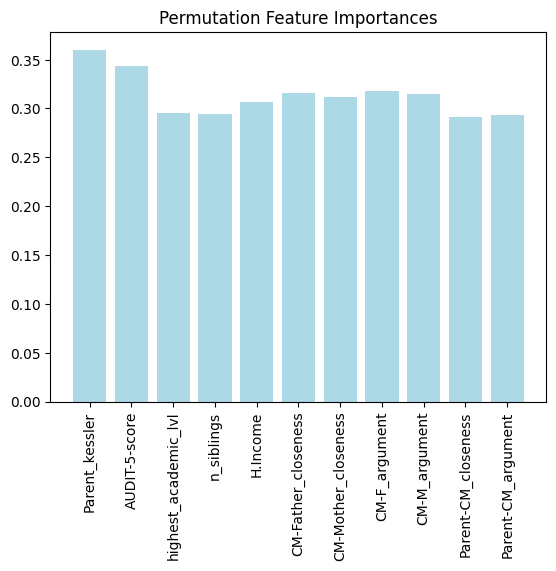

In [ ]:
#Feature importance

accuracy_xgboost = accuracy_score(y_test, predicted_y2)

#feature importance via permutation
perm_importances = []
for features in x_test.columns:
    x_test_permuted = x_test.copy()
    x_test_permuted[features] = np.random.permutation(x_test_permuted[features])
    permuted_accuracy = accuracy_score(y_test, xgboost_final.predict(x_test_permuted))
    perm_importances.append(accuracy_xgboost - permuted_accuracy)

# Score of importance per feature
for feature, importance in zip(x_test.columns, perm_importances):
    print(f"{feature}: {importance}")

# graphical illustration
plt.figure()
plt.title("Permutation Feature Importances")
plt.bar(range(len(x_test.columns)), perm_importances, align="center")
plt.xticks(range(len(x_test.columns)), x_test.columns, rotation="vertical")
plt.show()


MODEL BUILDING: SVM
- Train using training set
- Evaluate performance using validation set and performance metrics (Accuracy, precision, recall, f1-score, confusion matrix)
- Building model with optimised hyperparameters using combined training-validation set
- Evaluate model on testing set

In [ ]:
#1. Training SVM using training set

#Initialising SVM model with default hyperparameters
svm_1 = svm.SVC()
svm_1.fit(x_train_norm, y_train)

SVC()

In [ ]:
#2. Evaluating performance on validation set

#Fitting model on validation set
svm_y_pred1 = svm_1.predict(x_val_norm)

#Precision, recall, f1-score
print('Accuracy = ',accuracy_score(y_val, svm_y_pred1))
print('Precision = ',precision_score(y_val, svm_y_pred1))
print('recall = ',recall_score(y_val, svm_y_pred1))
print('f1-score = ',f1_score(y_val, svm_y_pred1))

print(classification_report(y_val,svm_y_pred1))
print('--')
print(confusion_matrix(y_val,svm_y_pred1))

Accuracy =  0.7249536178107606
Precision =  0.7263751763046544
recall =  0.7189390414146114
f1-score =  0.7226379794200186
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      2163
           1       0.73      0.72      0.72      2149

    accuracy                           0.72      4312
   macro avg       0.72      0.72      0.72      4312
weighted avg       0.72      0.72      0.72      4312

--
[[1581  582]
 [ 604 1545]]


In [ ]:
#3. Optimising hyperparameters using GridsearchCV and validation set

  #Parameters to be tuned (commonly optimised SVM hyperparameters in many literatures such as https://assets.researchsquare.com/files/rs-2316713/v1/bb29f83d-0180-4fe3-a67c-e4c7b3287141.pdf?c=1678563866)
    # C
    # kernel
    # gama

    #Defining the search space within gridsearchCV
param_grid_svm = {
    'C': [0.1, 1, 10], # Regularisation parameter
    'kernel': ['linear', 'poly','rbf','sigmoid'],  # Controls how drastic changes are to parameters during gradient descent each time a new tree is added
    'gamma': ['scale', 'auto']  # Max number of leaves. Higher max_depth increases risk of overfitting.
}

#Initialising 2nd SVM model for finding optimal hyperparameters
svm_2 = svm.SVC()

#Using gridsearchCV
grid_search_SVM = GridSearchCV(estimator=svm_2, param_grid=param_grid_svm, cv=5, n_jobs=-1)
grid_search_SVM.fit(x_val_norm, y_val)

#optimal hyperparameters chosen among those in the search space

print(grid_search_SVM.best_params_) #{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
highest_score_svm = grid_search_SVM.best_score_
highest_score_svm #accuracy = 0.7265780891671797

0.7265780891671797

In [ ]:
#Initialising new svm model with optimised hyperparameters
svm_final = svm.SVC(C=10,kernel='rbf', gamma="auto")

#Training new SVM model with optimised hyperparameters using training-validation combo dataset
svm_final.fit(x_train_val, y_train_val)

SVC(C=10, gamma='auto')

In [ ]:
#evaluating optimised SVM model on testing set
svm_y_pred2 = svm_final.predict(x_test_norm)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [ ]:
print('Accuracy = ',accuracy_score(y_test, svm_y_pred2))
print('Precision = ',precision_score(y_test, svm_y_pred2))
print('recall = ',recall_score(y_test, svm_y_pred2))
print('f1-score = ',f1_score(y_test, svm_y_pred2))

print(classification_report(y_test,svm_y_pred2))
print('--')
print(confusion_matrix(y_test,svm_y_pred2))

Accuracy =  0.8164022636608219
Precision =  0.8080115481775533
recall =  0.8303356202484702
f1-score =  0.8190214906264289
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      5386
           1       0.81      0.83      0.82      5393

    accuracy                           0.82     10779
   macro avg       0.82      0.82      0.82     10779
weighted avg       0.82      0.82      0.82     10779

--
[[4322 1064]
 [ 915 4478]]


MODEL BUILDING: KNN
- Train using training set
- Evaluate performance using validation set and performance metrics (Accuracy, precision, recall, f1-score, confusion matrix)
- Building model with optimised hyperparameters using combined training-validation set
- Evaluate model on testing set

In [ ]:
#Initialising KNN with default hyperprameters from sklearn library
knn_model1 = KNeighborsClassifier()
knn_model1.fit(x_train_norm, y_train)

KNeighborsClassifier()

In [ ]:
#Evaluating knn performance on validation set

##Fitting model on validation set
knn_y_pred1 = knn_model1.predict(x_val_norm)
knn_y_pred1

array([1, 0, 1, ..., 1, 0, 1])

In [ ]:
#Precision, recall, f1-score of knn model
print('Accuracy = ',accuracy_score(y_val, knn_y_pred1))
print('Precision = ',precision_score(y_val, knn_y_pred1))
print('recall = ',recall_score(y_val, knn_y_pred1))
print('f1-score = ',f1_score(y_val, knn_y_pred1))

print(classification_report(y_val,knn_y_pred1))
print('--')
print(confusion_matrix(y_val,knn_y_pred1))

Accuracy =  0.8594619666048238
Precision =  0.8070035813768405
recall =  0.9436947417403444
f1-score =  0.8700128700128701
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      2163
           1       0.81      0.94      0.87      2149

    accuracy                           0.86      4312
   macro avg       0.87      0.86      0.86      4312
weighted avg       0.87      0.86      0.86      4312

--
[[1678  485]
 [ 121 2028]]


In [ ]:
#optimising hyperparameters

  #Parameters to be tuned
    #1. n_neighbors
    #2. Metric
    #3. weights


  #Defining the search space within gridsearchCV
param_grid_knn = {
    'n_neighbors': [3,6,12], # Number of neighboring datapoints to use. Higher value --> underfitting https://towardsdatascience.com/k-nearest-neighbors-94395f445221#:~:text=As%20K%20increases%2C%20the%20KNN,and%20flexibility%20of%20the%20model.
    'metric': ['minkowski', 'manhattan',"euclidean"],  # Method of calculating distance between data points
    'weights': ['distance', 'uniform']  # Controls how much influence neighboring data points have over predictions
}


#Initialising 2nd knn model for finding optimal hyperparameters
knn_model2 = KNeighborsClassifier()

#Using gridsearchCV
grid_search_knn = GridSearchCV(estimator=knn_model2, param_grid=param_grid_knn, cv=5, n_jobs=-1)
grid_search_knn.fit(x_val_norm, y_val)

#optimal hyperparameters chosen among those in the search space
print(grid_search_knn.best_params_) #{'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}

{'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}


In [ ]:
highest_score_knn = grid_search_knn.best_score_
highest_score_knn #accuracy = 0.8005567907773294

0.8005567907773294

In [ ]:
#Building model with optimised hyperparameters using combined training-validation set

#Initialising new knn model with optimised hyperparameters
knn_final = KNeighborsClassifier(n_neighbors = 3, metric = 'manhattan', weights='distance')

#Training new knn model with optimised hyperparameters using training-validation combo dataset
knn_final.fit(x_train_val, y_train_val)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [ ]:
#evaluating optimised knn model on testing set
knn_y_pred2 = knn_final.predict(x_test_norm)

print('Accuracy = ',accuracy_score(y_test, knn_y_pred2))
print('Precision = ',precision_score(y_test, knn_y_pred2))
print('recall = ',recall_score(y_test, knn_y_pred2))
print('f1-score = ',f1_score(y_test, knn_y_pred2))

print(classification_report(y_test,knn_y_pred2))
print('--')
print(confusion_matrix(y_test,knn_y_pred2))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Accuracy =  0.9310696725113647
Precision =  0.9037860368183397
recall =  0.9649545707398479
f1-score =  0.9333692045556452
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      5386
           1       0.90      0.96      0.93      5393

    accuracy                           0.93     10779
   macro avg       0.93      0.93      0.93     10779
weighted avg       0.93      0.93      0.93     10779

--
[[4832  554]
 [ 189 5204]]


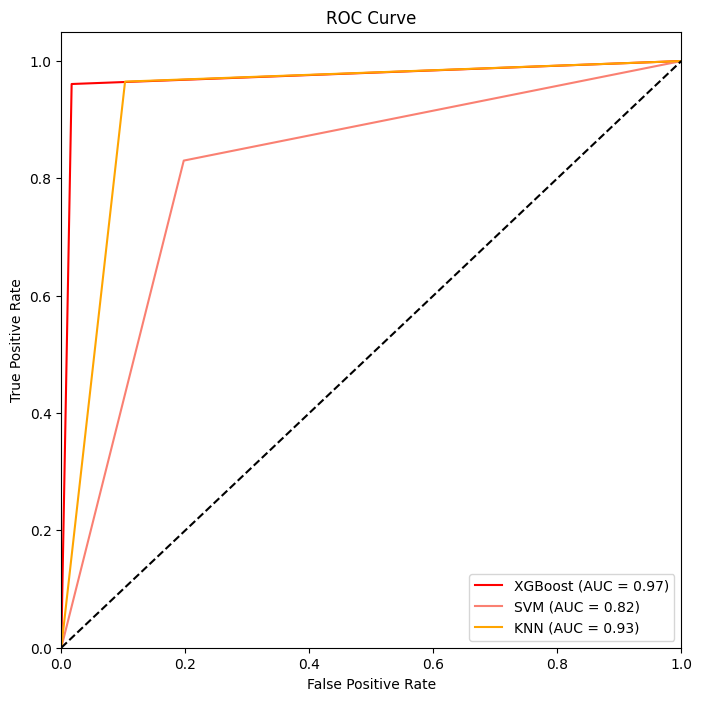

In [ ]:
#AUC results for each optimised model
false_pos_xgboost, true_pos_xgboost, _ = roc_curve(y_test, predicted_y2)
auc_xgboost = auc(false_pos_xgboost, true_pos_xgboost)

false_pos_svm, true_pos_svm, _ = roc_curve(y_test, svm_y_pred2)
auc_svm = auc(false_pos_svm, true_pos_svm)

false_pos_knn, true_pos_knn, _ = roc_curve(y_test, knn_y_pred2)
auc_knn = auc(false_pos_knn, true_pos_knn)

#Plotting AUC
plt.figure(figsize=(8, 8))
plt.plot(false_pos_xgboost, true_pos_xgboost, label='XGBoost (AUC = %.2f)' % auc_xgboost, color='red')
plt.plot(false_pos_svm, true_pos_svm, label='SVM (AUC = %.2f)' % auc_svm, color='salmon')
plt.plot(false_pos_knn, true_pos_knn, label='KNN (AUC = %.2f)' % auc_knn, color='orange')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



McNemar Test

In [ ]:
#Locating file containing SDQ score at age 14
file_path_SDQ14 = '/content/drive/MyDrive/H&S Data science Dissertation/UKDA-8156-spss-age14/spss/spss25/mcs6_cm_derived.sav'
sdq14, meta7 = pyreadstat.read_sav(file_path_SDQ14)
sdq_score_14_all = pd.DataFrame(sdq14)
sdq_score_14_all

# FEBDTOT (variable name) = Parent-reported CM SDQ Total Difficulties
sdq_score_14_final = sdq_score_14_all[['MCSID','FEBDTOT']] #Obtaining ID column and SDQ score at 14y/o column
sdq_score_14_final
###########################################

#Renaming column names into more meaningful names
sdq_score_14_final.rename(
    columns={"FEBDTOT": "CM_SDQ14"},
    inplace=True,
)
sdq_score_14_final

#Transforming SDQ scores at age 14 into binary (low risk = less than 17. High risk = 17 and above)
sdq_score_14_final['Mental_health14'] = sdq_score_14_final['CM_SDQ14'].apply(lambda x: 1 if x >= 17 else 0)
sdq_score_14_final ##0 = low-risk. 1 = high-risk in developing mental health

#Getting rid of CM_SDQ14 column as this is no longer needed
sdq_score_14_final = sdq_score_14_final.drop('CM_SDQ14', axis=1)
sdq_score_14_final

<ipython-input-38-10578924fcc1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdq_score_14_final.rename(
<ipython-input-38-10578924fcc1>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdq_score_14_final['Mental_health14'] = sdq_score_14_final['CM_SDQ14'].apply(lambda x: 1 if x >= 17 else 0)


,MCSID,Mental_health14
0,M10002P,0
1,M10007U,0
2,M10015U,0
3,M10016V,0
4,M10018X,0
...,...,...
11854,M35868P,0
11855,M35869Q,0
11856,M35872K,0
11857,M35873L,1


In [ ]:
#Merging mental health variable at age 14 and 17
merged_mental_health = pd.merge(sdq_score_14_final, cm_derived_s7_final, on='MCSID', how='inner')
merged_mental_health

#Transforming CM-SDQ17 into binary using same threshold
merged_mental_health['Mental_health17'] = merged_mental_health['CM_SDQ17'].apply(lambda x: 1 if x >= 17 else 0)
#0 = low-risk. 1 = high-risk in developing mental health

merged_mental_health_final = merged_mental_health.drop('CM_SDQ17', axis=1)
merged_mental_health_final

,MCSID,Mental_health14,Mental_health17
0,M10002P,0,0
1,M10007U,0,0
2,M10015U,0,0
3,M10016V,0,0
4,M10018X,0,0
...,...,...,...
10182,M35864K,1,0
10183,M35868P,0,0
10184,M35869Q,0,0
10185,M35872K,0,0


In [ ]:
#Performing Wilcoxon signed-ranked test

group_14 = merged_mental_health_final['Mental_health14']
group_17 = merged_mental_health_final['Mental_health17']

stats, p_value = wilcoxon(group_14, group_17)

print('stats = ', stats) #Upward change means risk of mental health increased from age 14 to 17.
print('p value = ', p_value) #statistically significant

stats =  162624.0
p value =  1.6133975823741526e-08


In [ ]:
#performing McNemar test
# Create contingency table
contingency_table = pd.crosstab(merged_mental_health_final['Mental_health14'], merged_mental_health_final['Mental_health17'])

# Perform McNemar test
result = mcnemar(contingency_table, exact=True)  # Use exact=True for small sample sizes

# Print McNemar test result
print("McNemar Statistic:", result.statistic)
print("P-value:", result.pvalue)



McNemar Statistic: 363.0
P-value: 1.7834524478315916e-08
